# Exploring ACTS data characteristics

In this notebook I'm now using ACTS cluster data for some exploratory analysis to try and answer some questions quantitatively:
- Numbers of tracks, numbers of hits on tracks
- Track density in the detector volumes and in local neighborhoods.

In [1]:
from __future__ import print_function

import ast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

## Utilities

### Data processing utilities

In [2]:
def load_data(file_name, columns):
    """Read the data into a pandas dataframe"""
    print('Loading', file_name)
    with open(file_name) as f:
        df = pd.DataFrame(
            [ast.literal_eval(line) for line in f
             if line.strip() and line[0] != "#"])
    # Rename the columns to something useful
    df.columns = columns
    return df

def load_data_events(file_name, columns, print_freq=100):
    """
    Load data from file into a dataframe.
    This function will detect each event and adds an evtid column.
    """
    dfs = []
    print('Loading', file_name)
    with open(file_name) as f:
        event_lines = []
        # Loop over lines in the file
        for line in f:
            # Add to current event
            if line.strip() and line[0] != '#':
                event_lines.append(ast.literal_eval(line))
            
            # Finalize a complete event
            elif len(event_lines) > 0:
                evtid = len(dfs)
                if (evtid % print_freq) == 0:
                    print('Finished event', evtid)
                df = pd.DataFrame(event_lines)
                df.columns = columns
                df['evtid'] = evtid
                dfs.append(df)
                event_lines = []
        # Verify there are no leftovers (otherwise fix this code)
        assert len(event_lines) == 0
    
    # Concatenate the events together into one DataFrame
    return pd.concat(dfs, ignore_index=True)

def process_hits_data(df, copy_keys=['evtid', 'hitid', 'barcode', 'volid', 'layid']):
    """Split columns and calculate some derived variables"""
    hits = pd.DataFrame(df[copy_keys])
    hits['x'] = df.gpos.apply(lambda pos: pos[0])
    hits['y'] = df.gpos.apply(lambda pos: pos[1])
    hits['z'] = df.gpos.apply(lambda pos: pos[2])
    hits['r'] = np.sqrt(hits.x**2 + hits.y**2)
    hits['phi'] = np.arctan2(hits.y, hits.x)
    hits['theta'] = np.arctan2(hits.r, hits.z)
    hits['eta'] = -1. * np.log(np.tan(hits.theta / 2.))
    return hits

def process_particles_data(df, copy_keys=['evtid', 'barcode', 'q']):
    """Split columns and calculate some derived variables"""
    particles = pd.DataFrame(df[copy_keys])
    particles['vx'] = df.vpos.apply(lambda pos: pos[0])
    particles['vy'] = df.vpos.apply(lambda pos: pos[1])
    particles['vz'] = df.vpos.apply(lambda pos: pos[2])
    particles['p'] = df.kin.apply(lambda kin: kin[0])
    particles['theta'] = df.kin.apply(lambda kin: kin[1])
    particles['phi'] = df.kin.apply(lambda kin: kin[2])
    particles['pt'] = particles.p * np.sin(particles.theta)
    particles['eta'] = -1. * np.log(np.tan(particles.theta / 2.))
    return particles

### Visualization utilities

In [3]:
def draw_hist(a, xlabel=None, **kwargs):
    plt.hist(a, **kwargs)
    if xlabel is not None:
        plt.xlabel(xlabel)

def draw_scatter(x, y, s=1, marker='.', xlabel=None, ylabel=None, label=None, **kwargs):
    plt.scatter(x, y, s=s, marker=marker, label=label, **kwargs)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

## Load the data

For now we're playing with some low-occupancy, "easy" data, with pileup mu=10 and a 1 GeV pt cut.

In [4]:
hits = pd.read_pickle('hits_df.pkl')

In [5]:
particles = pd.read_pickle('particles_df.pkl')

In [6]:
print('Processed hits data shape:', hits.shape)
print('First 5 entries:')
hits.head()

Processed hits data shape: (49741, 12)
First 5 entries:


,evtid,hitid,barcode,volid,layid,x,y,z,r,phi,theta,eta
0,0,0,0,1,1,-4.656602,-0.155955,9.806181,4.659213,-3.108114,0.443555,1.489496
1,0,1,0,1,2,-7.023466,-0.607201,14.566574,7.049664,-3.055354,0.450735,1.472890
2,0,2,0,1,3,-10.314437,-1.435089,21.297991,10.413793,-3.003346,0.454774,1.463656
3,0,3,0,3,1,-25.453171,-8.748733,54.333439,26.914758,-2.810525,0.459931,1.451977
4,0,4,0,3,1,-25.637516,-8.893391,54.381195,27.136223,-2.807691,0.462847,1.445426


In [7]:
print('Processed particle data shape:', particles.shape)
print('First few entries:')
particles.head()

Processed particle data shape: (4049, 11)
First few entries:


,evtid,barcode,q,vx,vy,vz,p,theta,phi,pt,eta
0,0,0,-1.0,0.243134,0.406200,0.057693,1.254330,0.468539,-3.077120,0.566434,1.432752
1,0,1,1.0,0.246463,0.382222,-1.592140,0.664279,1.868282,-2.913812,0.635102,-0.301973
2,0,2,1.0,0.239392,0.411095,-0.040770,2.893044,2.847671,-2.894507,0.838137,-1.910355
3,0,3,-1.0,0.241369,0.415060,-2.564666,1.056629,0.454668,-3.023555,0.464034,1.463897
4,0,4,-1.0,0.243410,0.395718,-13.173409,0.787669,1.774494,-2.926673,0.771384,-0.205121


## Event visualizations
Visualize the tracks and hits in one event.

In [8]:
# Choose an event to play with
ievt = 2
evt_hits = hits[hits.evtid == ievt]
evt_pids = np.unique(evt_hits.barcode)

### Scatter plots - whole detector

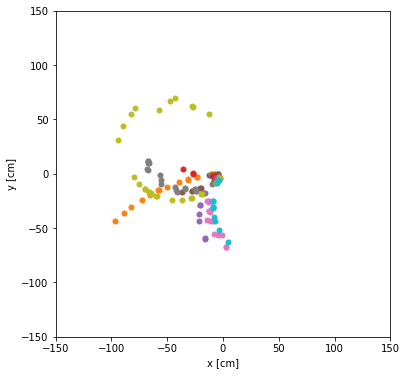

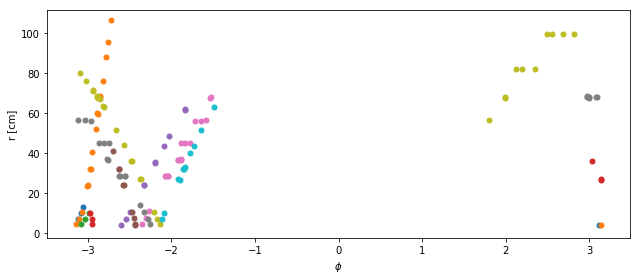

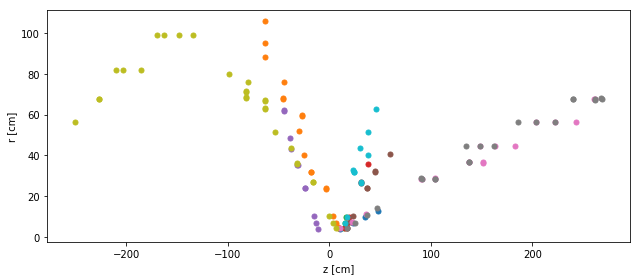

In [21]:
boundary=150
plt.figure(figsize=(6,6))
#only first few tracks
selected_evt_pids=evt_pids[:10]
for pid in selected_evt_pids:#only first few tracks
    par_hits = evt_hits[evt_hits.barcode == pid]
    draw_scatter(par_hits.x, par_hits.y, s=100)
plt.xlim((-boundary, boundary))
plt.ylim((-boundary, boundary))
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')

plt.figure(figsize=(9,4))
for pid in selected_evt_pids:
    par_hits = evt_hits[evt_hits.barcode == pid]
    draw_scatter(par_hits.phi, par_hits.r, s=100)
plt.xlabel('$\phi$')
plt.ylabel('r [cm]')
plt.tight_layout()

plt.figure(figsize=(9,4))
for pid in selected_evt_pids:
    par_hits = evt_hits[evt_hits.barcode == pid]
    draw_scatter(par_hits.z, par_hits.r, s=100)
plt.xlabel('z [cm]')
plt.ylabel('r [cm]')
plt.tight_layout()

### Scatter plots - individual detector layers

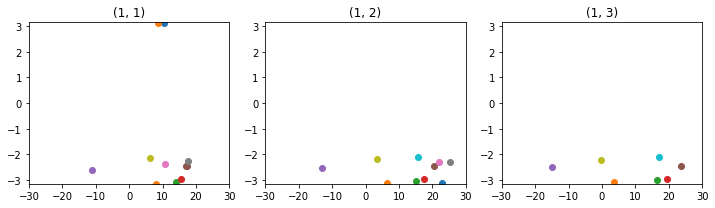

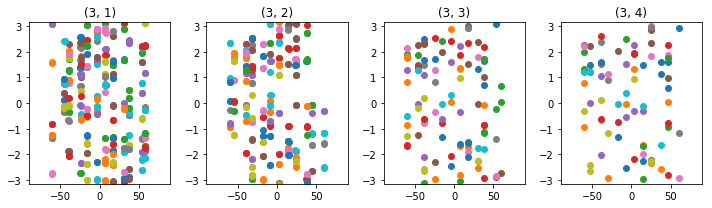

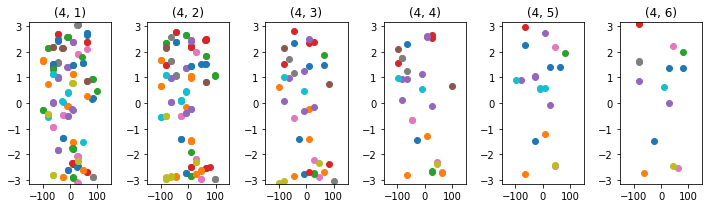

In [38]:
# bpix
plt.figure(figsize=(10,3))
vol_hits = evt_hits[evt_hits.volid == 1]
for lid in [1,2,3]:
    plt.subplot(1, 3, lid)
    lay_hits = vol_hits[vol_hits.layid == lid]
    for pid in selected_evt_pids:
        par_hits = lay_hits[lay_hits.barcode == pid]
        plt.scatter(par_hits.z, par_hits.phi)
        plt.xlim((-30, 30))
        plt.ylim((-np.pi, np.pi))
        plt.title((1,lid))
plt.tight_layout()

# tib
plt.figure(figsize=(10,3))
vol_hits = evt_hits[evt_hits.volid == 3]
for lid in [1,2,3,4]:
    plt.subplot(1, 4, lid)
    lay_hits = vol_hits[vol_hits.layid == lid]
    for pid in evt_pids:
        par_hits = lay_hits[lay_hits.barcode == pid]
        plt.scatter(par_hits.z, par_hits.phi)
        plt.xlim((-90, 90))
        plt.ylim((-np.pi, np.pi))
        plt.title((3,lid))
plt.tight_layout()

# tob
plt.figure(figsize=(10,3))
vol_hits = evt_hits[evt_hits.volid == 5]
for lid in [1,2,3,4,5,6]:
    plt.subplot(1, 6, lid)
    lay_hits = vol_hits[vol_hits.layid == lid]
    for pid in evt_pids:
        par_hits = lay_hits[lay_hits.barcode == pid]
        plt.scatter(par_hits.z, par_hits.phi)
        plt.xlim((-150, 150))
        plt.ylim((-np.pi, np.pi))
        plt.title((4,lid))
plt.tight_layout()

## Event distributions

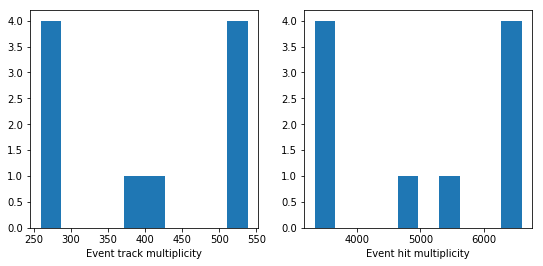

In [39]:
# Track and hit multiplicities
plt.figure(figsize=(9,4))
plt.subplot(121)
draw_hist(particles.groupby('evtid').size(), xlabel='Event track multiplicity')
plt.subplot(122)
draw_hist(hits.groupby('evtid').size(), xlabel='Event hit multiplicity')

Let's make some histograms of the hit counts in each detector volume. How about I use one plot for a volume, and show each histogram superimposed for each layer.

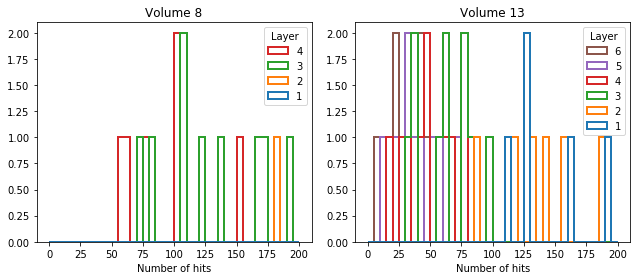

In [42]:
plt.figure(figsize=(9,4))

plt.subplot(121)
vol_hits = hits[hits.volid == 3]
counts = []
layers = []
for lay, lay_hits in vol_hits.groupby('layid'):
    counts.append(lay_hits.groupby('evtid').size())
    layers.append(lay)

draw_hist(counts, range=(0,200), bins=40,
          histtype='step', alpha=1, linewidth=2,
          label=layers, xlabel='Number of hits')
plt.legend(loc=0, title='Layer')
plt.title('TIB')

plt.subplot(122)
vol_hits = hits[hits.volid == 5]
counts = []
layers = []
for lay, lay_hits in vol_hits.groupby('layid'):
    counts.append(lay_hits.groupby('evtid').size())
    layers.append(lay)

draw_hist(counts, range=(0,200), bins=40,
          histtype='step', alpha=1, linewidth=2,
          label=layers, xlabel='Number of hits')
plt.legend(loc=0, title='Layer')
plt.title('TOB')

plt.tight_layout()

In [43]:
# I can construct a series of hit counts indexed by event, volume, and layer,
# but this data structure is kinda difficult to work with, so I'm not sure
# it's worthwhile enough. Let's leave this here as a reference for now
hit_counts = hits.groupby(['evtid', 'volid', 'layid']).size()
hit_counts.head()

evtid  volid  layid
0      1      1        357
              2        290
              3        256
       2      1        148
              2         93
dtype: int64

## Track distributions

Let's now look at things like the number of hits on a track, the kinematics, and the track shapes.

To calculate the dphi, I need to pick the first hit and the last hit.

In [44]:
def df_calc_dphi(df):
    """Within a group (a particle) of hits, calculate
    the absolute change in phi between the first and last hit,
    as sorted in cylindrical r.
    """
    phi = df.sort_values('r').phi.values
    dphi = np.abs(phi[-1] - phi[0])
    if dphi > np.pi:
        dphi = 2*np.pi - dphi
    return dphi

par_groups = hits.groupby(['evtid', 'barcode'])
nhits = par_groups.size()
dphi = par_groups.apply(df_calc_dphi).values
deta = par_groups.eta.max() - par_groups.eta.min()

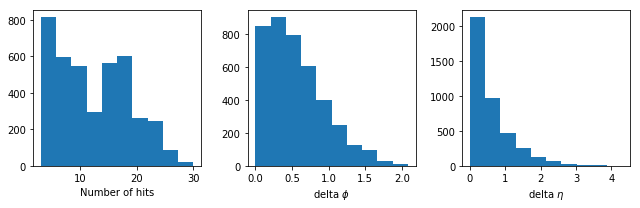

In [45]:
plt.figure(figsize=(9,3))
plt.subplot(131)
draw_hist(nhits, xlabel='Number of hits')
plt.subplot(132)
draw_hist(dphi, log=False, xlabel='delta $\phi$')
plt.subplot(133)
draw_hist(deta, xlabel='delta $\eta$')
plt.tight_layout()

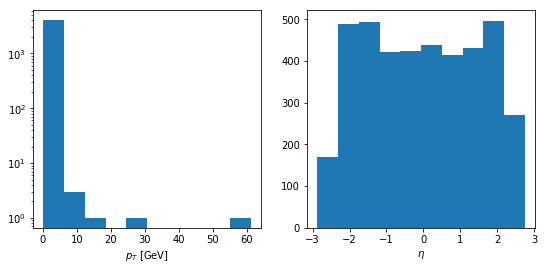

In [46]:
plt.figure(figsize=(9,4))
plt.subplot(121)
draw_hist(particles.pt, log=True, xlabel='$p_T$ [GeV]')
plt.subplot(122)
draw_hist(particles.eta, xlabel='$\eta$')

In [47]:
def calc_dphi(phi1, phi2):
    dphi = np.abs(phi1 - phi2)
    idx = dphi > np.pi
    dphi[idx] = 2*np.pi - dphi[idx]
    return dphi

def calc_dR(eta1, eta2, phi1, phi2):
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(deta*deta + dphi*dphi)

In [48]:
# Let's calculate the delta-phi between hits and their true particle phi.
# It should roughly correspond to how much tracks deviate in phi from their initial value.
# I should be able to accomplish this with a join.
hp = hits.merge(particles, on=['evtid'], how='inner', suffixes=['_hit', '_par'])
sig_hp = hp[hp.barcode_hit == hp.barcode_par]
bkg_hp = hp[hp.barcode_hit != hp.barcode_par]

sig_dphi = calc_dphi(sig_hp.phi_hit, sig_hp.phi_par)
sig_deta = np.abs(sig_hp.eta_hit - sig_hp.eta_par)
sig_dR = calc_dR(sig_hp.eta_hit, sig_hp.eta_par, sig_hp.phi_hit, sig_hp.phi_par)

bkg_dphi = calc_dphi(bkg_hp.phi_hit, bkg_hp.phi_par)
bkg_deta = np.abs(bkg_hp.eta_hit - bkg_hp.eta_par)
bkg_dR = calc_dR(bkg_hp.eta_hit, bkg_hp.eta_par, bkg_hp.phi_hit, bkg_hp.phi_par)

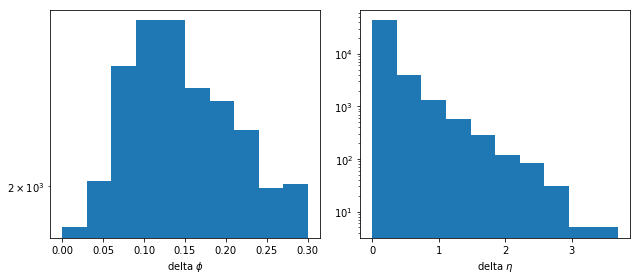

In [49]:
plt.figure(figsize=(9,4))
plt.subplot(121)
draw_hist(sig_dphi, log=True, range=(0, 0.3), xlabel='delta $\phi$')
plt.subplot(122)
draw_hist(sig_deta, log=True, xlabel='delta $\eta$')
plt.tight_layout()

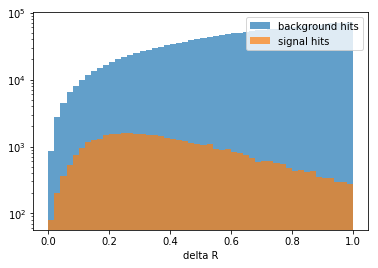

In [50]:
# To understand 
plt.figure()
kwargs = dict(log=True, range=(0, 1), bins=50, alpha=0.7,
              xlabel='delta R')
draw_hist(bkg_dR, label='background hits', **kwargs)
draw_hist(sig_dR, label='signal hits', **kwargs)
plt.legend(loc=1);

## Track densities

What exactly do we want to plot here?
We want to learn something about the neighborhood around a track.
We want to know how many other track hits are in the vicinity, relative to the usual spread of a track itself.

Maybe what I actually want is to show the above histograms drawn along with the other-particle hits on the same axis.
Let's start by trying to make the equivalent plot as above but for hits from different particles.

To calculate this, maybe I can do some kind of equivalent merge which joins on the evtid but inverts the barcode match.

In [51]:
few_particles = particles.sample(5)

In [52]:
hp = few_particles.merge(hits, on='evtid', suffixes=['_par', '_hits'])
bkg = hp[hp.barcode_par != hp.barcode_hits]
bkg_dphi = calc_dphi(bkg.phi_hits, bkg.phi_par)

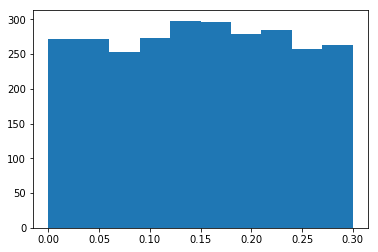

In [53]:
plt.figure()
draw_hist(bkg_dphi, range=(0, 0.3))

## Visualizing tracks
Now let's look at the regions around some tracks to get an intuitive sense of the track density.

In [76]:
pid = np.random.choice(evt_pids)
print(pid)
par_hits = evt_hits[evt_hits.barcode == pid]
print(par_hits)
r_window = (0, 120)
phi_window = par_hits.phi.min() - 0.2, par_hits.phi.max() + 0.2
z_window = par_hits.z.min(), par_hits.z.max()
other_hits = evt_hits[(evt_hits.barcode != pid) &
                      (evt_hits.phi > phi_window[0]) &
                      (evt_hits.phi < phi_window[1])]
print(other_hits)

270
       evtid  hitid  barcode  volid  layid          x          y           z  \
15006      2      0      270      1      1  -1.903034   4.216029  -23.174553   
15007      2      1      270      2      1  -3.755890   7.090373  -34.728069   
15008      2      2      270      2      2  -6.083652  10.369220  -48.337349   
15009      2      3      270      4      2 -17.001654  23.292324  -90.614685   
15010      2      4      270      4      2 -16.714186  23.758799  -90.860039   
15011      2      5      270      4      3 -17.615387  22.448557 -106.170547   
15012      2      6      270      4      3 -17.801075  22.748911 -106.415367   
15013      2      7      270      6      1 -24.077480  27.793268 -129.857803   
15014      2      8      270      6      1 -24.160967  27.996670 -130.186905   
15015      2      9      270      6      2 -30.161282  33.114681 -141.627060   
15016      2     10      270      6      2 -24.940878  27.131313 -143.851105   
15017      2     11      270      6 

Text(0.5, 0, 'z')

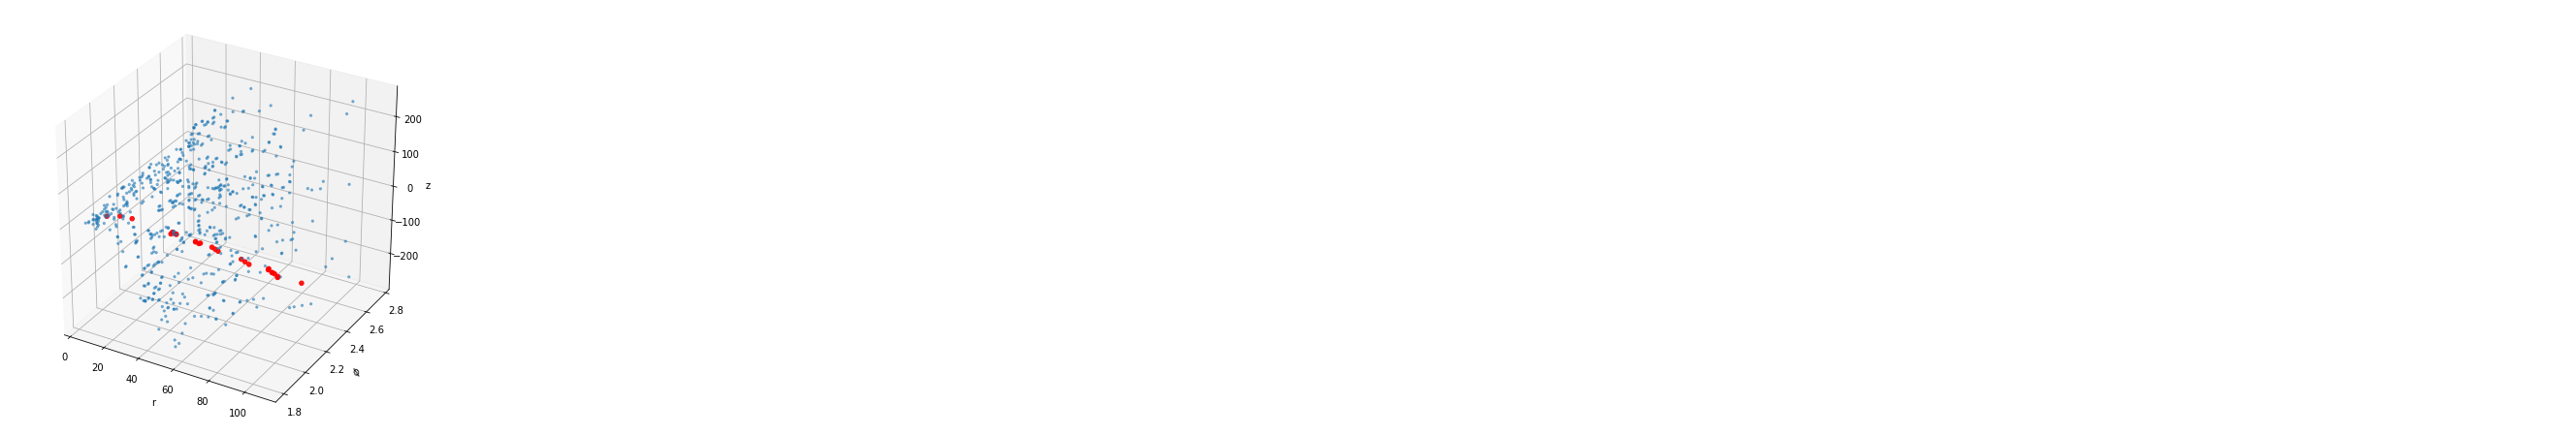

In [78]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(par_hits.r, par_hits.phi, par_hits.z, s=20, c='r',alpha=0.9)
ax.scatter(other_hits.r, other_hits.phi, other_hits.z,alpha=0.5,s=5)
ax.set_xlabel('r')
ax.set_ylabel('$\phi$')
ax.set_zlabel('z')
# ax.set_xlim((0, par_hits.r.max()))
# ax.set_ylim3d((par_hits.phi.min(), par_hits.phi.max()))
# ax.set_xlim((0, 10))
# ax.set_ylim3d((-3, 3))
# ax.set_zlim3d((-10, 10))
# plt.tight_layout()